In [30]:
import torch
import clip
import sys
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import json
import tqdm
from argparse import Namespace


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [8]:
sys.path.append(os.path.join(os.path.abspath(""), "./../clip/LoRA/"))

from loralib.utils import (
    apply_lora,
    load_lora,
)

In [9]:
def get_random_cub_images(n: int, directory: str) -> list:
    """ Get n random images as PIL Image objects from the cub dataset for testing purposes """
    
    images_dir = os.path.join(directory, "images")
    classes = os.listdir(images_dir)
    
    random_classes = random.choices(classes, k=n)
    
    random_images = []  
    for cls in random_classes:
        cls_dir = os.path.join(images_dir, cls)
        images = os.listdir(cls_dir)
        random_images.append(Image.open(os.path.join(cls_dir, random.choice(images))))
        
    return random_images

## Experiment 1 : Studying Image similarity given a text concept

In [10]:
def most_least_concept_similarity(model: torch.nn.Module, images: list[torch.tensor], concept: str, device: str = "cuda") -> tuple:
    """ Get the 3 images indices that most ressemble a concept and the 3 that least ressemble it for clip"""
    most, least = [], []
    concept_tok = clip.tokenize([concept]).to(device)
    images_tensor = torch.stack(images).to(device)
    
    with torch.no_grad():
        logits_per_image, logits_per_text = model(images_tensor, concept_tok)
        probs = logits_per_text.softmax(dim=-1).cpu().numpy()

    most = probs.argsort(axis=1)[0, -3:]
    least = probs.argsort(axis=1)[0, :3]
    
    return most, least
    

In [11]:
def plot_images_two_rows(images_top: list[torch.tensor], images_low: list[torch.tensor]):
    """ Plot two rows of images """
    images = images_top + images_low
    n = len(images_top)
    fig, ax = plt.subplots(2, n, figsize=(8, 5))
    
    for i, img in enumerate(images):
        ax[i//n, i%n].imshow(img)
        ax[i//n, i%n].axis("off")

    plt.tight_layout()
    plt.show()

In [36]:
args = Namespace(**{
    # Model backbone type (e.g., CLIP backbone)
    'backbone': 'ViT-B/16',  # Default: 'ViT-B/16'

    # LoRA-specific arguments
    # Defines where to insert LoRA modules within the model's layers
    'position': 'all',  # Options: 'bottom', 'mid', 'up', 'half-up', 'half-bottom', 'all', 'top3'; Default: 'all'
    # Determines whether to apply LoRA to the text encoder, vision encoder, or both
    'encoder': 'both',  # Options: 'text', 'vision', 'both'; Default: 'both'
    # Specifies which attention matrices in the model will use LoRA
    'params': ('q', 'k', 'v'),  # Default: Query (q), Key (k), and Value (v) matrices
    # The rank of the low-rank matrices used in LoRA
    'r': 2,  # Default: 2
    # Scaling factor applied to LoRA matrices (see LoRA paper for details)
    'alpha': 1,  # Default: 1
    # Dropout rate applied before the LoRA module
    'dropout_rate': 0.25,  # Default: 0.25

    # Filename for saving LoRA weights (without extension)
    'filename': 'lora_weights',  # Default: 'lora_weights'    
    # Path to save the LoRA weights after training; will not save if set to None
    'save_path': "./../clip/LoRA/weights/"  # Default: './../clip/LoRA/weights/'
})

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [37]:
list_lora_layers = apply_lora(args, model)
load_lora(args, list_lora_layers)

LoRA weights loaded from ./../clip/LoRA/weights//lora_weights.pt


/Data/hugo.aoyagi/PRIM/VisCoIN/experiments/./../clip/LoRA/loralib/utils.py:281: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(load_path)


In [38]:
def convert_model_to_float32(model):
    """Converts all weights in a PyTorch model to float32 precision."""
    for param in model.parameters():
        if param.dtype == torch.float16:  # Check if the parameter is in half-precision
            param.data = param.data.float()  # Convert the parameter data to float32
        if param.grad is not None and param.grad.dtype == torch.float16:  # Convert gradient, if it exists
            param.grad.data = param.grad.data.float()
    return model

model = convert_model_to_float32(model)

model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): PlainMultiheadAttentionLoRA(
            (q_proj): LinearLoRA(
              in_features=768, out_features=768, bias=True
              (dropout): Dropout(p=0.25, inplace=False)
            )
            (k_proj): LinearLoRA(
              in_features=768, out_features=768, bias=True
              (dropout): Dropout(p=0.25, inplace=False)
            )
            (v_proj): LinearLoRA(
              in_features=768, out_features=768, bias=True
              (dropout): Dropout(p=0.25, inplace=False)
            )
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequen

In [9]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [44]:
images = get_random_cub_images(3000, "./../datasets/CUB_200_2011")
images_preprocess = [preprocess(img).to(device) for img in images]

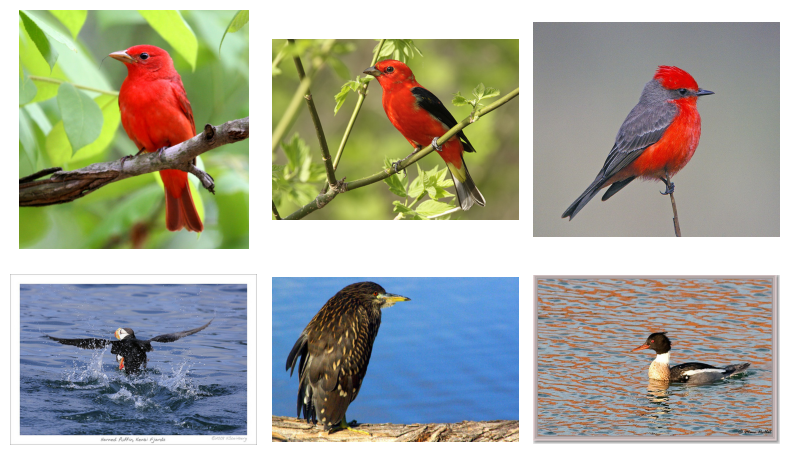

In [48]:
most, least = most_least_concept_similarity(model, images_preprocess, "red", device)
plot_images_two_rows([images[i] for i in most], [images[i] for i in least])

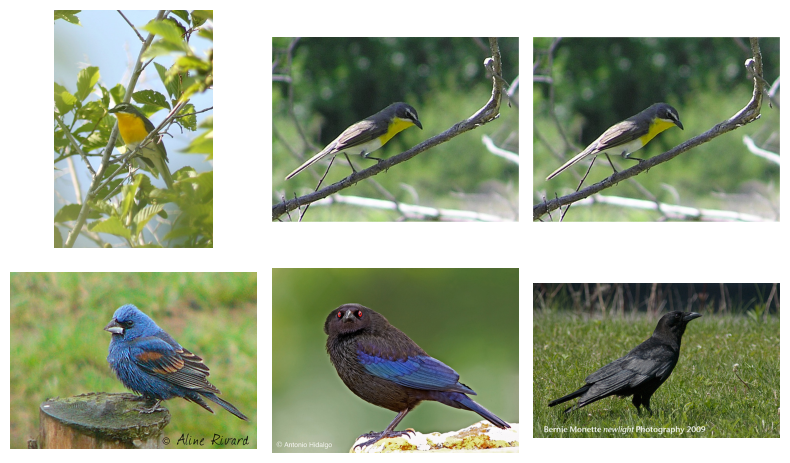

In [56]:
most, least = most_least_concept_similarity(model, images_preprocess, "yellow tail", device)
plot_images_two_rows([images[i] for i in most], [images[i] for i in least])

> *Observations :* 
CLIP understands basic concepts (colors, body parts), but is very bad with compositionality of concepts ("red beak", "blue wings"). Usually, the simplest concept will take over, the color for instance. 

Some work a bit better when a concept doesn't take over : beak + pointed

## Experiment 2 : Embedding difference in CLIP with generated vocab

In [23]:
def forward_difference(model: torch.nn.Module, image_a: torch.tensor, image_b: torch.tensor, text: torch.tensor):
    """Performs the CLIP forward but with the difference of two images"""
    image_a_features = model.encode_image(image_a)
    image_b_features = model.encode_image(image_b)
    
    image_diff_features = image_b_features - image_a_features
    
    text_features = model.encode_text(text)

    # normalized features
    image_features = image_diff_features / image_diff_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

    # cosine similarity as logits
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()

    # shape = [global_batch_size, global_batch_size]
    return logits_per_image, logits_per_text

def forward_difference_embedding(model: torch.nn.Module, image: torch.tensor, embedding: torch.tensor, text: torch.tensor):
    """Performs the CLIP forward but with the difference of two images"""
    image_features = model.encode_image(image)
    
    image_diff_features = image_features - embedding
    
    text_features = model.encode_text(text)

    # normalized features
    image_features = image_diff_features / image_diff_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

    # cosine similarity as logits
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()

    # shape = [global_batch_size, global_batch_size]
    return logits_per_image, logits_per_text

In [24]:
def get_best_labels(model: torch.nn.Module, image: torch.tensor, labels_tok: torch.tensor) -> list:
    with torch.no_grad():
        logits_per_image, logits_per_text = model(image, labels_tok)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    best = probs.argsort(axis=1)[0, -3:][::-1]
    return [(i, probs[0, i]) for i in best]

def get_best_labels_minus_avg_embedding(model: torch.nn.Module, image: torch.tensor, avg_embedding: torch.tensor, labels_tok: torch.tensor) -> list:
    with torch.no_grad():
        logits_per_image, logits_per_text = forward_difference_embedding(model, image, avg_embedding, labels_tok)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    best = probs.argsort(axis=1)[0, -3:][::-1]
    return [(i, probs[0, i]) for i in best]

def get_best_labels_diff(model: torch.nn.Module, image_a: torch.tensor, image_b: torch.tensor, labels_tok: torch.tensor) -> list:
    with torch.no_grad():
        logits_per_image, logits_per_text = forward_difference(model, image_a, image_b, labels_tok)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    best = probs.argsort(axis=1)[0, -3:][::-1]
    return [(i, probs[0, i]) for i in best]

In [33]:
def load_vocab(file_path: str) -> list:
    with open(file_path, 'r') as f:
        labels = f.readlines()
    labels = [label.strip() for label in labels]
    labels_tok = clip.tokenize(labels).to(device)
    return labels_tok, labels

labels_tok, labels = load_vocab("vocab/example_labels.txt")

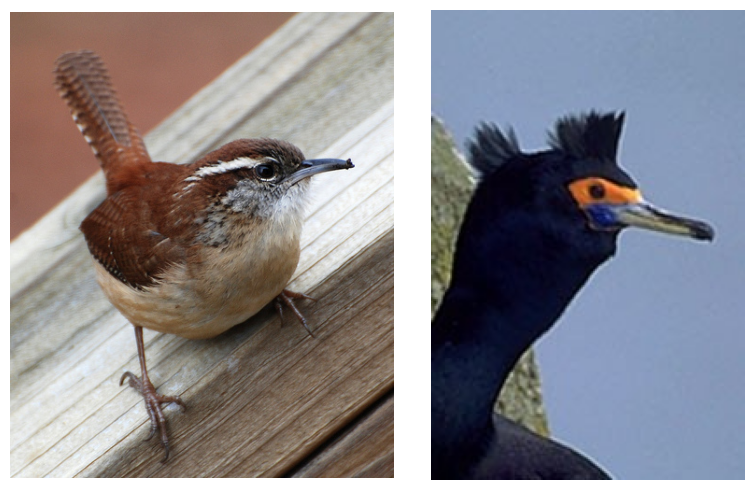

Best labels for image A:
Brown beak 0.26654643
Brown tail 0.14281468
Pointed beak 0.08829456

Best labels for image B:
Pointed beak 0.22348715
Curved beak 0.121522464
Narrow beak 0.111148976

Best labels for the difference between image A and B:
Yellow claws 0.22671163
Long neck 0.10395743
Yellow neck 0.068127416


In [27]:
#Indices of the two images to compare
a, b = random.randint(0, len(images)), random.randint(0, len(images))

image_a_preproc = images_preprocess[a].unsqueeze(0)
image_b_preproc = images_preprocess[b].unsqueeze(0)



def plot_embedding_diff(model: torch.nn.Module, image_a_preproc: torch.tensor, image_a: Image, image_b_preproc: torch.tensor, image_b: Image, labels_tok: torch.tensor, labels: list[str]):
    """
    Plots the two images and prints the 3 best labels for each image and the difference between them, prints each label and the normalized cosine similarity
        
        Parameters:
            model: CLIP model
            image_i_preproc (torch tensor): Preprocessed image tensor
            image_i (PIL Image): Image A
            labels_tok: Tokenized labels
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))

    ax[0].imshow(image_a)
    ax[0].axis("off")
    ax[1].imshow(image_b)
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

    print("Best labels for image A:")
    for best in get_best_labels(model, image_a_preproc, labels_tok):
        print(labels[best[0]], best[1])

    print("\nBest labels for image B:")
    for best in get_best_labels(model, image_b_preproc, labels_tok):
        print(labels[best[0]], best[1])
        
    print("\nBest labels for the difference between image A and B:")
    for best in get_best_labels_diff(model, image_a_preproc, image_b_preproc, labels_tok):
        print(labels[best[0]], best[1])

plot_embedding_diff(model, image_a_preproc, images[a], image_b_preproc, images[b], labels_tok, labels)

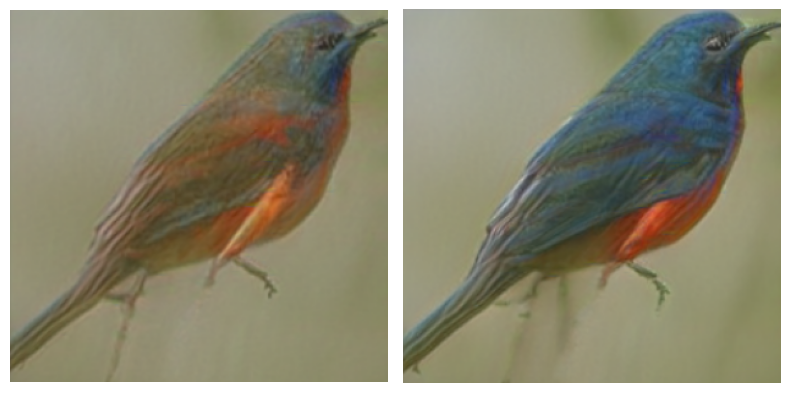

Best labels for image A:
Red beak 0.07069204
Pale throat 0.070100985
Curved beak 0.069313504

Best labels for image B:
Blue throat 0.17786916
Blue beak 0.1070362
Curved beak 0.09298242

Best labels for the difference between image A and B:
Blue 0.91831136
Blue chest 0.0408473
Cyan 0.01593396


In [30]:
# image_lbd1 = Image.open("images/redeye-lbd1.png")
# image_lbd4 = Image.open("images/redeye-lbd4.png")
image_lbd1 = Image.open("images/blueupper-lbd1.png")
image_lbd4 = Image.open("images/blueupper-lbd4.png")

image_lbd1_preproc = preprocess(image_lbd1).unsqueeze(0).to(device)
image_lbd4_preproc = preprocess(image_lbd4).unsqueeze(0).to(device)

plot_embedding_diff(model, image_lbd1_preproc, image_lbd1, image_lbd4_preproc, image_lbd4, labels_tok, labels)

### Adding the most common english words as the vocabulary

In [31]:
def load_batch_vocab(file_path: str, batch_size: int):
    """ Loads the vocab and batches the labels into a list of tuples with the index in the vocab for retrieval """
    with open(file_path, 'r') as f:
        labels = f.readlines()
    labels = [label.strip() for label in labels]
    return [(clip.tokenize(labels[i:i+batch_size]).to(device), i) for i in range(0, len(labels), batch_size)], labels

labels_tok_batch, labels = load_batch_vocab("vocab/google-10000-english.txt", 100)

100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


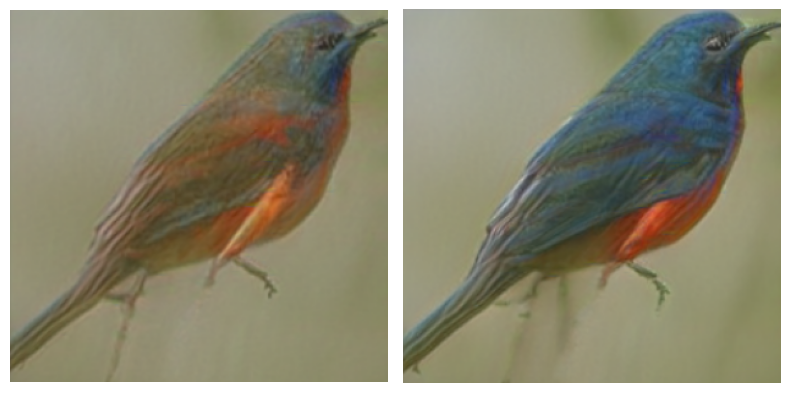

Best labels for image A:
verzeichnis 0.05891576
individual 0.045111667
male 0.03703346

Best labels for image B:
male 0.04506073
ecuador 0.040363993
verzeichnis 0.032409817

Best labels for the difference between image A and B:
blue 0.8378434
social 0.0356214
green 0.034748778


In [32]:
def get_best_labels_batch(model: torch.nn.Module, image: torch.tensor, labels_tok_batch: list[tuple[torch.tensor, int]]) -> list:
    best_per_batch = []
    for batch in tqdm.tqdm(labels_tok_batch):
        with torch.no_grad():
            logits_per_image, logits_per_text = model(image, batch[0])
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        best = probs.argsort(axis=1)[0, -5:][::-1]
        best_per_batch += [i + batch[1] for i in best]
    return best_per_batch

def get_best_labels_diff_batch(model: torch.nn.Module, image_a: torch.tensor, image_b: torch.tensor, labels_tok_batch: list[tuple[torch.tensor, int]]) -> list:
    best_per_batch = []
    for batch in tqdm.tqdm(labels_tok_batch):
        with torch.no_grad():
            logits_per_image, logits_per_text = forward_difference(model, image_a, image_b, batch[0])
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        best = probs.argsort(axis=1)[0, -5:][::-1]
        best_per_batch += [i + batch[1] for i in best]
    return best_per_batch

def plot_embedding_diff_batch(model: torch.nn.Module, image_a_preproc: torch.tensor, image_a: Image, image_b_preproc: torch.tensor, image_b: Image, labels_tok_batch: list[tuple[torch.tensor, int]], labels: list[str]):
    """Same as plot_embedding_diff but for a much larger vocab that doesn't fit in memory so we split the vocab in batches"""
    
    # Get the best labels for each batch in the large vocab
    best_labels_a = get_best_labels_batch(model, image_a_preproc, labels_tok_batch)
    best_labels_b = get_best_labels_batch(model, image_b_preproc, labels_tok_batch)
    best_labels_diff = get_best_labels_diff_batch(model, image_a_preproc, image_b_preproc, labels_tok_batch)
    
    # Create a new batch from those labels and run another pass on them
    labels_a = [labels[i] for i in best_labels_a]
    labels_b = [labels[i] for i in best_labels_b]
    labels_diff = [labels[i] for i in best_labels_diff]
    
    labels_a_tok = clip.tokenize(labels_a).to(device)
    labels_b_tok = clip.tokenize(labels_b).to(device)
    labels_diff_tok = clip.tokenize(labels_diff).to(device)
    
        
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))

    ax[0].imshow(image_a)
    ax[0].axis("off")
    ax[1].imshow(image_b)
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

    print("Best labels for image A:")
    for best in get_best_labels(model, image_a_preproc, labels_a_tok):
        print(labels_a[best[0]], best[1])

    print("\nBest labels for image B:")
    for best in get_best_labels(model, image_b_preproc, labels_b_tok):
        print(labels_b[best[0]], best[1])
        
    print("\nBest labels for the difference between image A and B:")
    for best in get_best_labels_diff(model, image_a_preproc, image_b_preproc, labels_diff_tok):
        print(labels_diff[best[0]], best[1])
    
    
plot_embedding_diff_batch(model, image_lbd1_preproc, image_lbd1, image_lbd4_preproc, image_lbd4, labels_tok_batch, labels)

## Experiment 3 : Segmenting images to remove background

In [35]:
import rembg

session = rembg.new_session("isnet-general-use")

ModuleNotFoundError: No module named 'rembg'

In [36]:
N = 50
segmented_images = [rembg.remove(image, session=session) for image in tqdm.tqdm(images[:N])]

labels_tok, labels = load_vocab("vocab/example_labels.txt")

  0%|          | 0/50 [00:00<?, ?it/s]


NameError: name 'rembg' is not defined

In [37]:
def plot_image_and_segmented(image: Image, segmented: Image):
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))

    ax[0].imshow(image)
    ax[0].axis("off")
    ax[1].imshow(segmented)
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()
    

In [38]:
a = random.randint(0, N - 1)

def compare_labels_segmentation(image, image_preproc, segmented_image):

    plot_image_and_segmented(image, segmented_images[a])

    print("Best labels for image A:")
    for best in get_best_labels(model, image_preproc.unsqueeze(0).to(device), labels_tok):
        print(labels[best[0]], best[1])
    print("\nBest labels for image A segmented:")
    for best in get_best_labels(model, preprocess(segmented_image).unsqueeze(0).to(device), labels_tok):
        print(labels[best[0]], best[1])

compare_labels_segmentation(images[a], images_preprocess[a], segmented_images[a])


NameError: name 'segmented_images' is not defined

> Working with segmented images seems to help, there are less incoherent labels, such as colors that are not at all on the bird.

## Substracting the average bird

In [39]:

embeddings = [model.encode_image(preprocess(image).unsqueeze(0).to(device)) for image in tqdm.tqdm(images[:N])]
embeddings_segmented = [model.encode_image(preprocess(segmented).unsqueeze(0).to(device)) for segmented in tqdm.tqdm(segmented_images[:N])]

avg_embedding = torch.stack(embeddings).mean(dim=0)
avg_embedding_segmented = torch.stack(embeddings_segmented).mean(dim=0)

100%|██████████| 50/50 [00:00<00:00, 66.84it/s]


NameError: name 'segmented_images' is not defined

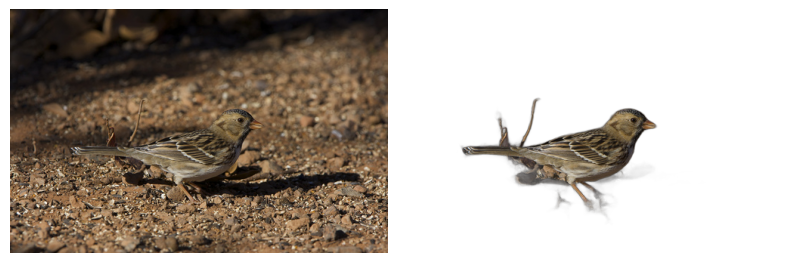

Best labels for image A:
Striped tail 0.2375
White throat 0.0945
Striped beak 0.07477

Best labels for image A segmented:
Striped tail 0.08514
Slim feathers 0.06036
Pale throat 0.05942


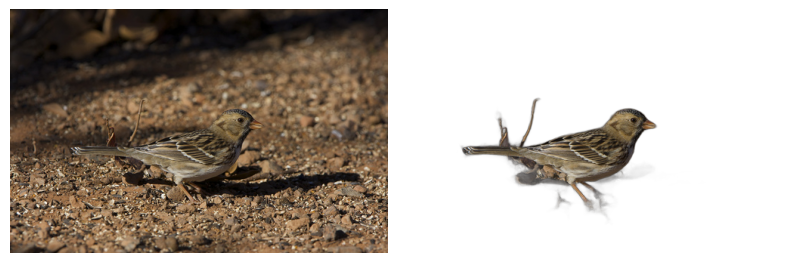

Best labels for image A:
Yellow stripe 0.477
Striped wings 0.2827
Yellow wings 0.0548

Best labels for image A segmented:
Striped legs 0.3325
Striped wings 0.2181
Yellow stripe 0.0742


In [43]:
a = random.randint(0, N - 1)

def compare_labels_segmentation_minus_average_embedding(image, image_preproc, segmented_image, avg_embedding, avg_embedding_segmented):

    plot_image_and_segmented(image, segmented_image)

    print("Best labels for image A:")
    for best in get_best_labels_minus_avg_embedding(model, image_preproc.unsqueeze(0).to(device), avg_embedding, labels_tok):
        print(labels[best[0]], best[1])
    print("\nBest labels for image A segmented:")
    for best in get_best_labels_minus_avg_embedding(model, preprocess(segmented_image).unsqueeze(0).to(device), avg_embedding_segmented, labels_tok):
        print(labels[best[0]], best[1])

compare_labels_segmentation(images[a], images_preprocess[a], segmented_images[a])
compare_labels_segmentation_minus_average_embedding(images[a], images_preprocess[a], segmented_images[a], avg_embedding, avg_embedding_segmented)


> There seems to be more general concepts when we substract the average embedding, for instance we might get only a color "Yellow" instead of "Yellow Wings", the descriptions seems to be more precise similarly to the difference of two embeddings.

## Another Contrastive Text Image Model : ALIGN (Google)

> ALIGN is a model developped by google, very similar to CLIP but trained on noisier labels and with different vision and text encoders.

In [26]:
from transformers import AlignProcessor, AlignModel

processor = AlignProcessor.from_pretrained("kakaobrain/align-base")
model = AlignModel.from_pretrained("kakaobrain/align-base")

model.to(device)

AlignModel(
  (text_model): AlignTextModel(
    (embeddings): AlignTextEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlignTextEncoder(
      (layer): ModuleList(
        (0-11): 12 x AlignTextLayer(
          (attention): AlignTextAttention(
            (self): AlignTextSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): AlignTextSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [27]:

def most_least_concept_similarity_align(model: torch.nn.Module, processor: torch.nn.Module, images: list[torch.tensor], concept: str, device: str = "cuda") -> tuple:
    """ Get the 3 images indices that most ressemble a concept and the 3 that least ressemble it for clip"""
    most, least = [], []
    
    
    
    with torch.no_grad():
        inputs = processor(images = images, text = [concept], return_tensors="pt").to(device)
        
        output = model(**inputs)
        probs = output.logits_per_text.softmax(dim=-1).cpu().numpy()

    most = probs.argsort(axis=1)[0, -3:]
    least = probs.argsort(axis=1)[0, :3]
    
    return most, least
    

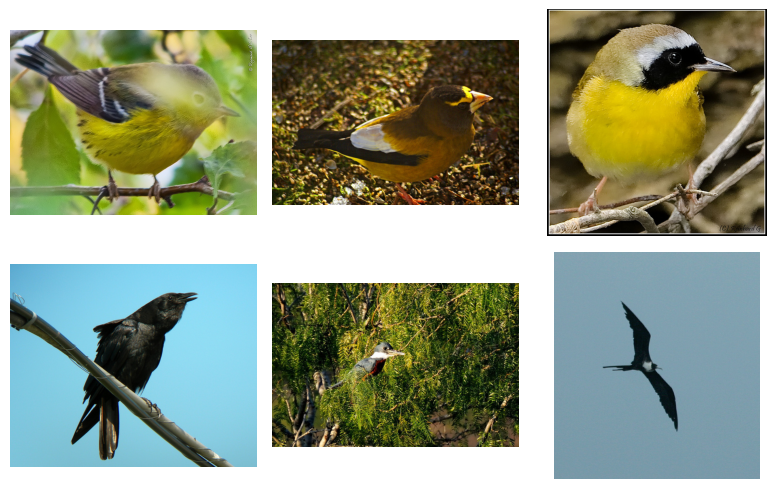

In [34]:
most, least = most_least_concept_similarity_align(model, processor, images[:200], "yellow belly", device)

plot_images_two_rows([images[i] for i in most], [images[i] for i in least])

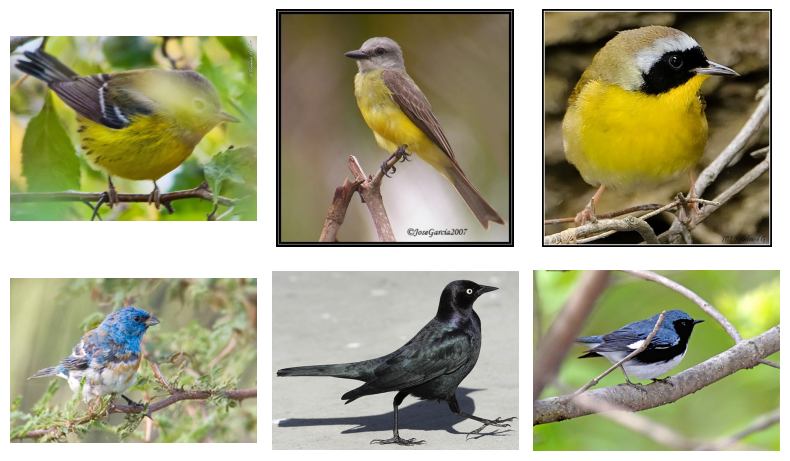

In [35]:
most, least = most_least_concept_similarity_align(model, processor, images[:200], "yellow head", device)

plot_images_two_rows([images[i] for i in most], [images[i] for i in least])

> Align seems similar to CLIP in terms of composition of concepts, the easier concepts take over more complex ones.
> Moreover, Align is much heavier in terms of memory.